In [1]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
# from transformers import AutoTokenizer
# import torch
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
from Levenshtein import distance as lev_distance

import os
from tqdm import tqdm
import random
import json
from collections import Counter
import pickle
import warnings

from IPython.core.interactiveshell import InteractiveShell

from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
data = create_date_features(data)

In [4]:
# drop columns with big share of missing values
data = remove_null_columns(data, threshold=.999)

In [5]:
X = data.drop(columns=['target', 'client_id', 'report_date'])
Y = data['target']

In [6]:
categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

In [7]:
X[numerical_columns] = X[numerical_columns].fillna(0)
X[categorical_columns] = X[categorical_columns].astype(str)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.33, random_state=42, shuffle=True)

# Stage 2. Data Analysis

### Data Inspection

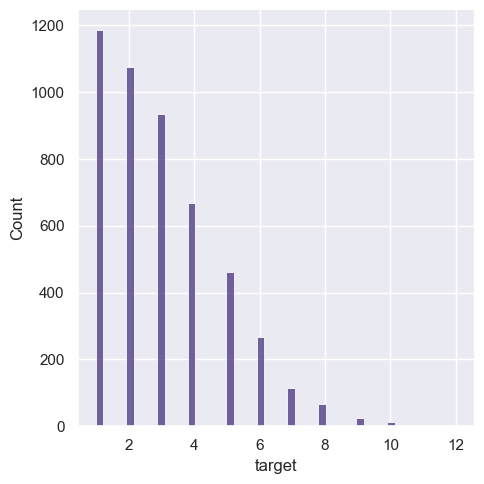

In [9]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [10]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

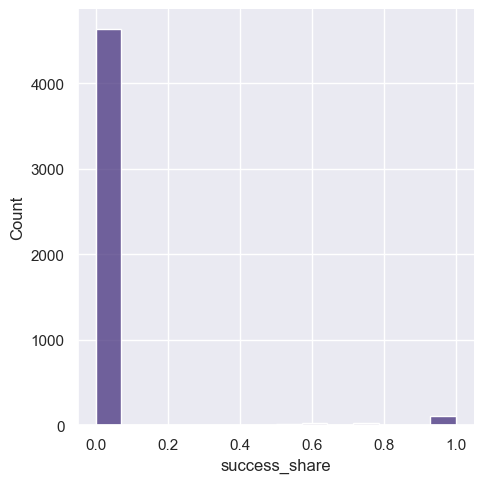

In [11]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

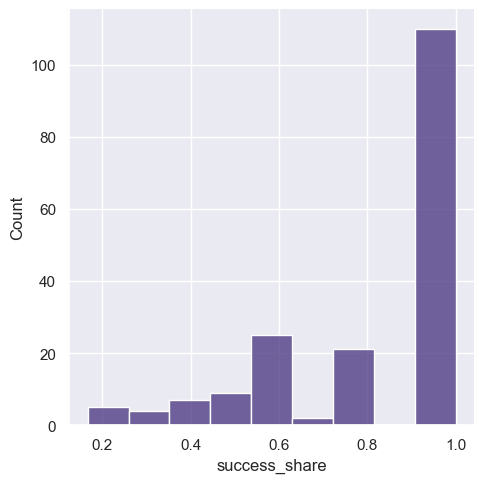

In [12]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [13]:
# share of clents with 1


### Plot Possible Clusters

In [14]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

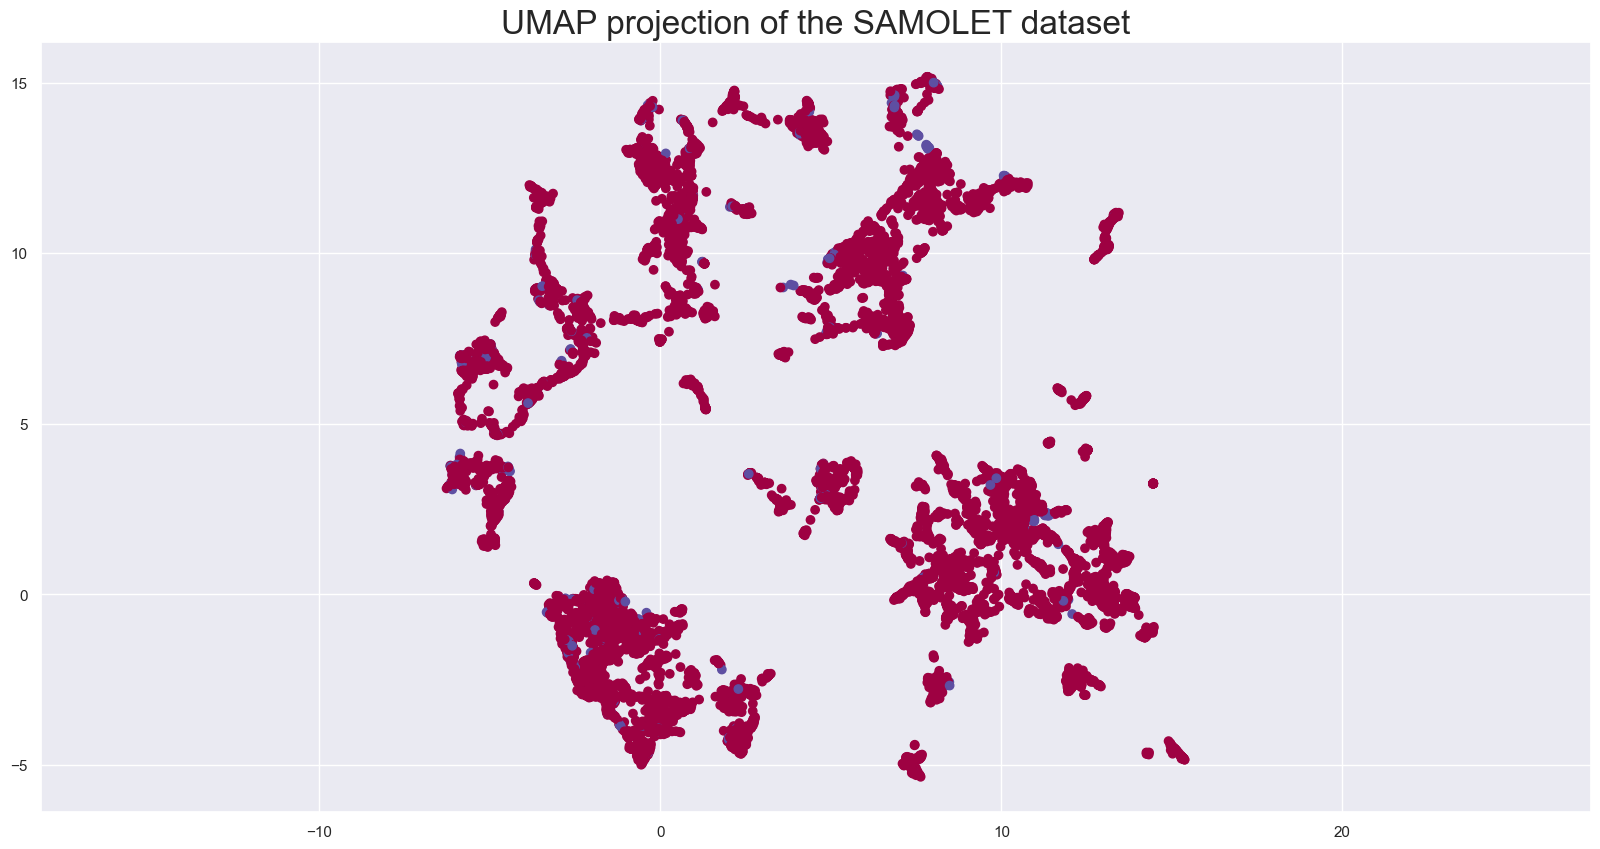

In [16]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [17]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [18]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [19]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

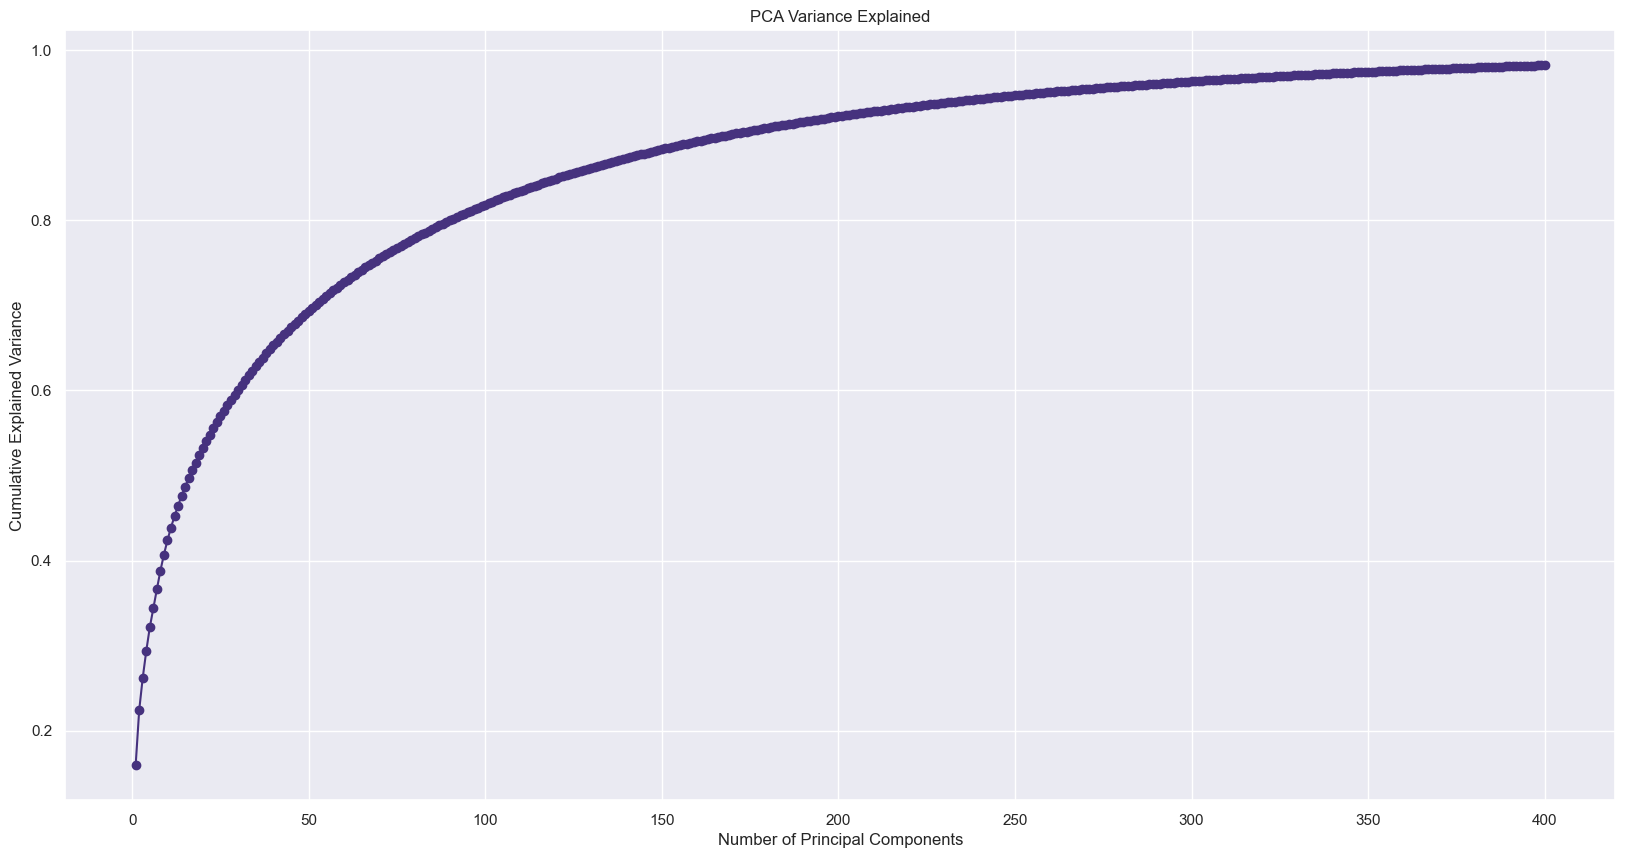

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [20]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

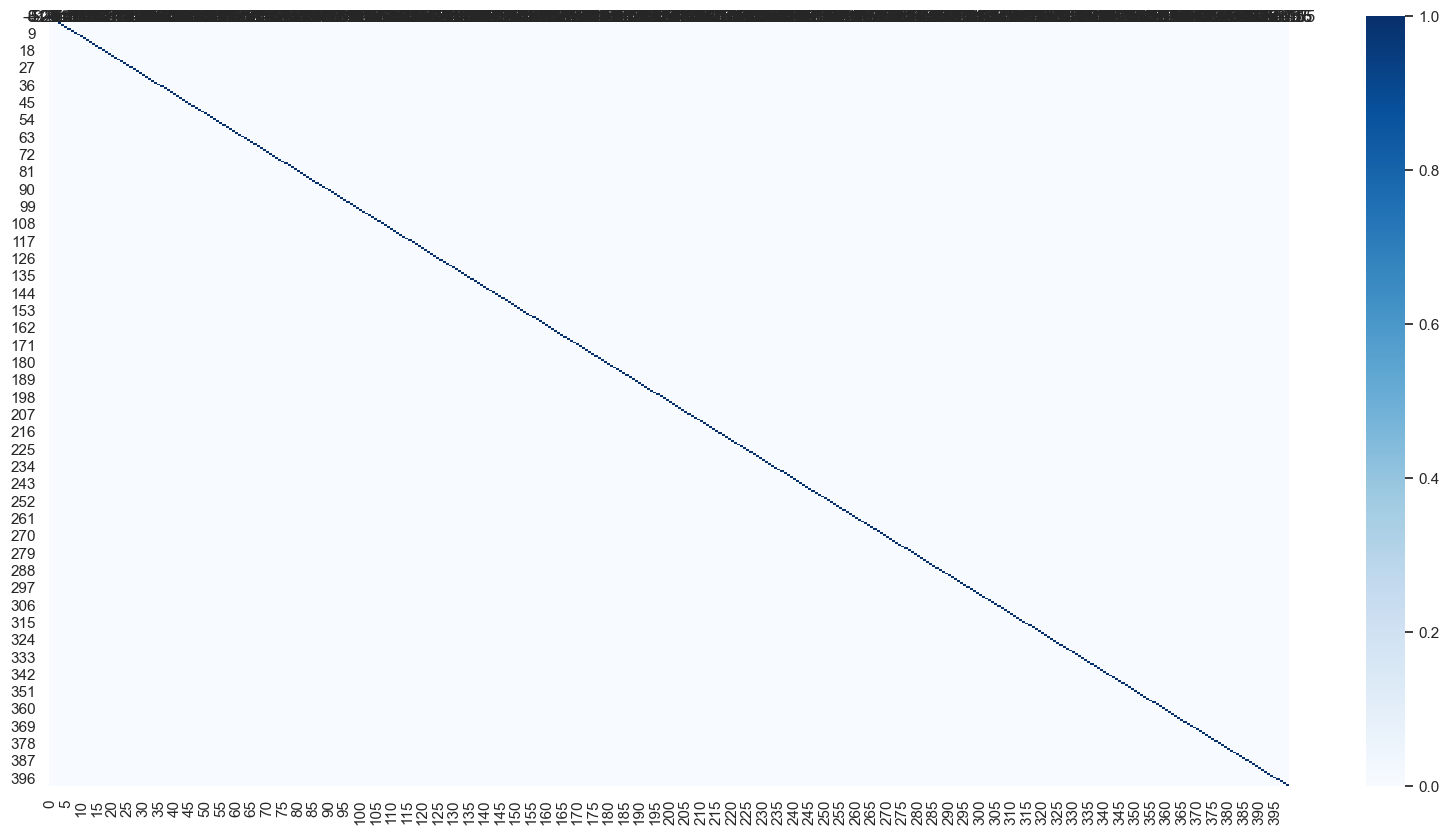

In [21]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [22]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.9072080887149381

ROC-AUC score is:  0.9072080887149381


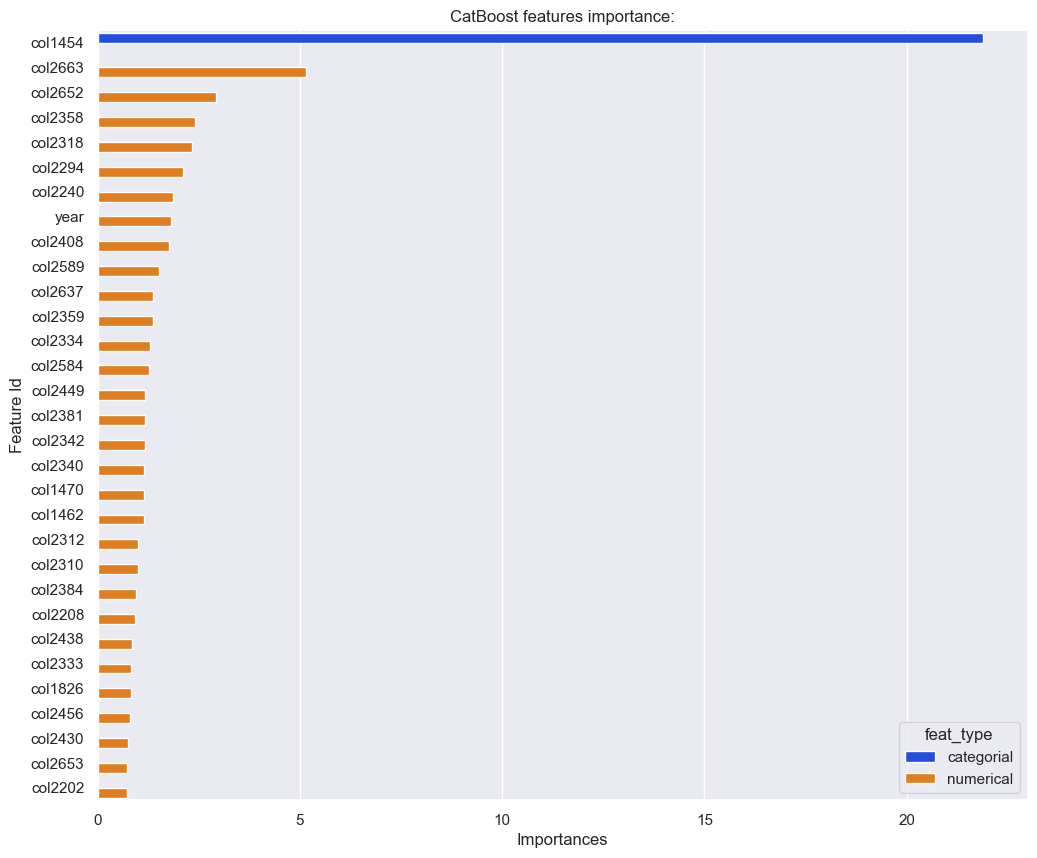

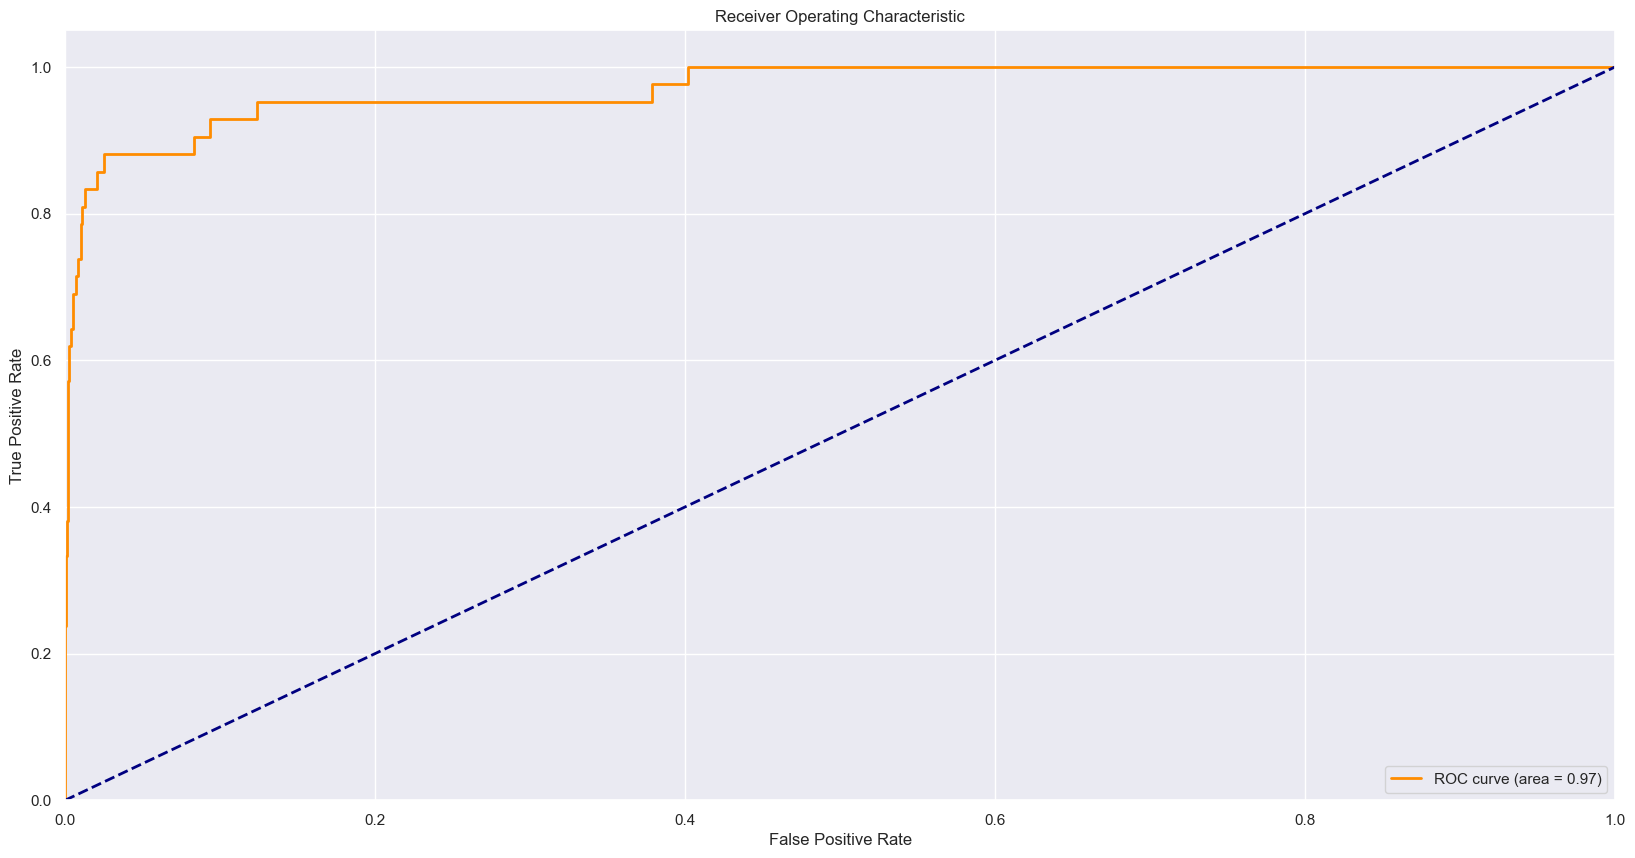

In [23]:
plot_model_info(model, X_test, y_test, categorical_columns)

# Step 4. Feature Selection

In [24]:
# Add statistics str vs num

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2023-09-09 16:04:57,856 INFO From 2407 feature 55 were selected (0.02%).Share of 'Object' type features is: 0.05%


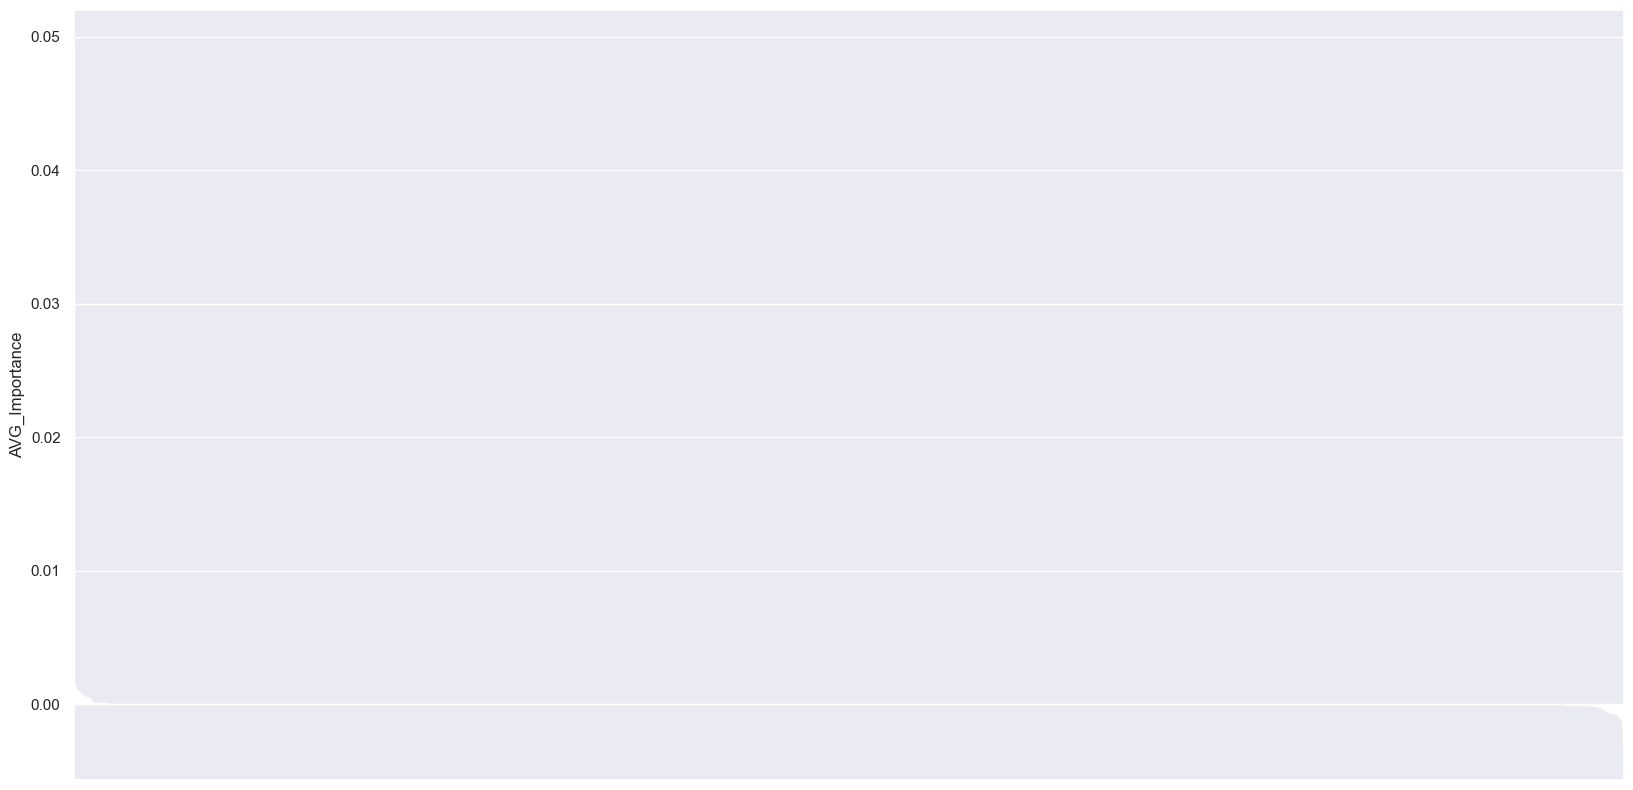

In [25]:
useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=True)
# useful_column_indices_rf = get_random_feat_important_features(model, X_train, y_train, y_valid)

In [26]:
X_train_cleaned = X_train.iloc[:, useful_column_indices_sk]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices_sk]
X_test_cleaned = X_test.iloc[:, useful_column_indices_sk]

In [27]:
def catboost_model_classifier(x_train, x_valid, y_train, y_valid):
    # categorical_features_indices = np.where(~X_train.dtypes.isin(['float64', 'int64']))[0]
    categorical_columns = x_train.select_dtypes(exclude=["float64", "int64"]).columns
    numerical_columns = x_train.select_dtypes(include=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(x_train, categorical_columns)

    x_train[numerical_columns] = x_train[numerical_columns].fillna(0).astype(int)
    x_valid[numerical_columns] = x_valid[numerical_columns].fillna(0).astype(int)

    x_train[categorical_columns] = x_train[categorical_columns].astype(str)
    x_valid[categorical_columns] = x_valid[categorical_columns].astype(str)

    cb_model = CatBoostClassifier(
        loss_function="Logloss",
        random_seed=42,
        logging_level="Silent",
        # custom_metric=['MAE', 'MAPE'],
        max_depth=8,
        iterations=200,
        # scale_pos_weight=26,
        auto_class_weights="Balanced",
        early_stopping_rounds=20,
        # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
    )

    if len(categorical_columns) > 0:
        cb_model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            cat_features=categorical_columns.to_list(),
            plot=True,
        )
    else:
        cb_model.fit(
            x_train,
            y_train,
            eval_set=(x_valid, y_valid),
            cat_features=categorical_columns.to_list(),
            plot=True,
        )

    return cb_model

In [28]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC score is:  0.9181343770384867


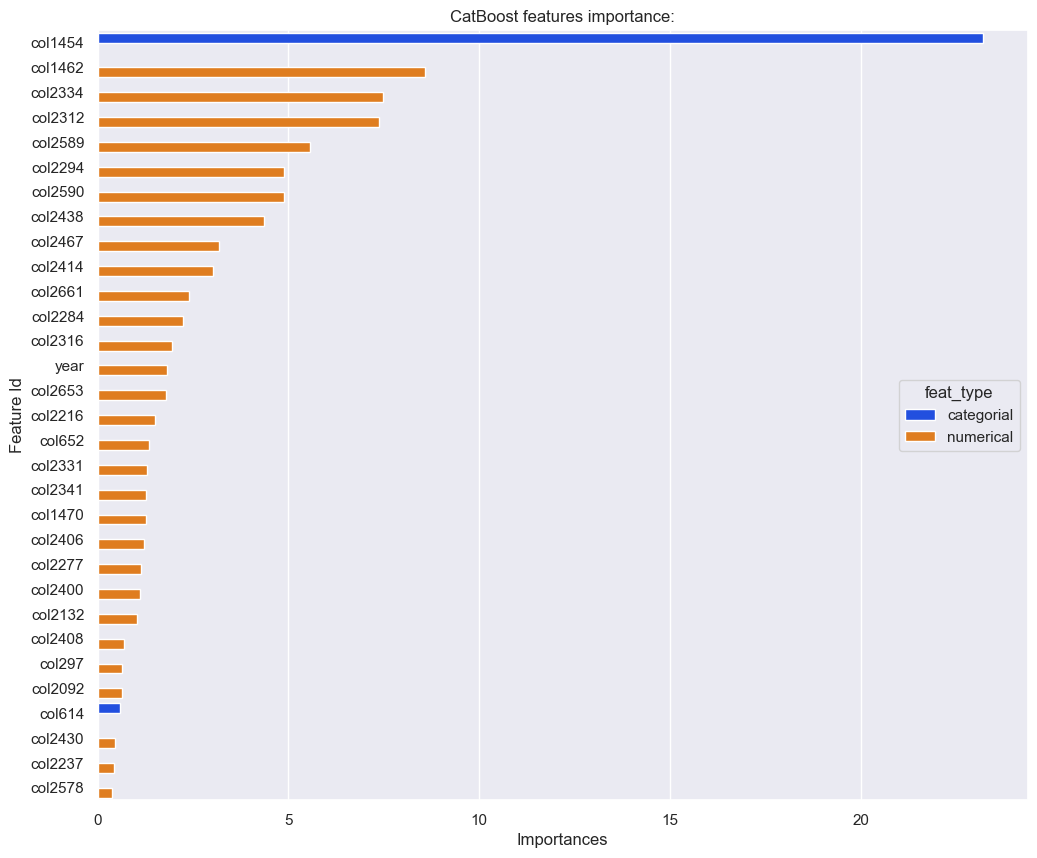

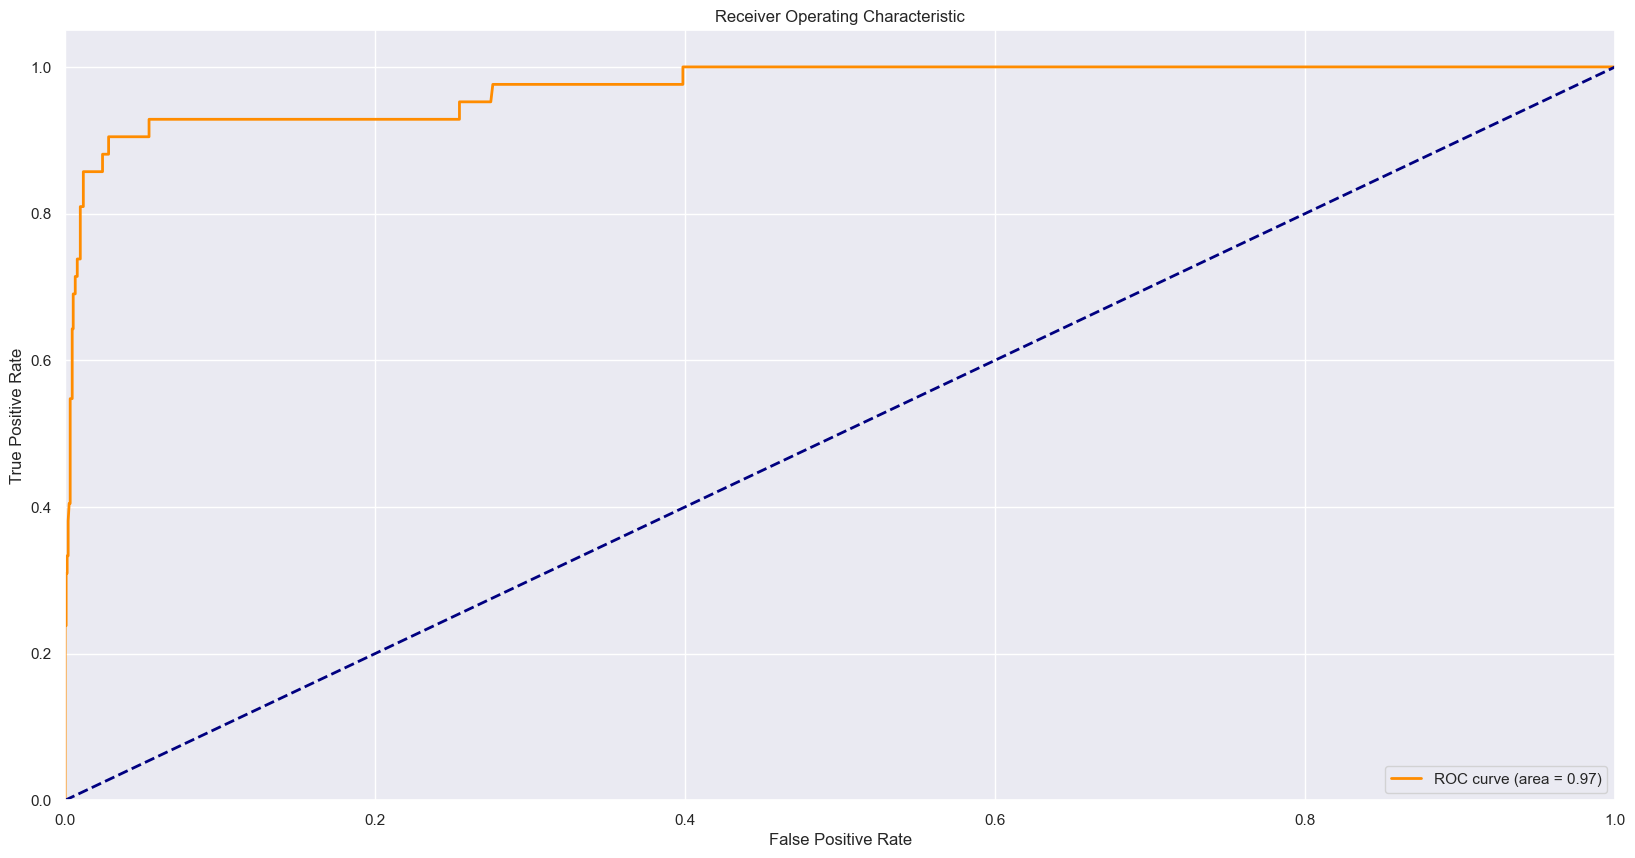

In [29]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
    X_test_cleaned.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
)

# Step 5. Hyperparameters Tuning

In [30]:
search_new_params = False
if search_new_params:
    hyperparams = search_best_params(X_train, X_test, y_train, y_test)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

In [31]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [32]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [33]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
# categorical_features_indices = get_column_indices(X_train, categorical_columns)
model_best = CatBoostClassifier(**params)
model_best.fit(X=X_train_cleaned, y=y_train, eval_set=(X_valid_cleaned, y_valid), verbose=250, cat_features=categorical_columns)
roc_auc_score(y_test, model_best.predict(X_test_cleaned))

0:	learn: 0.5002676	test: 0.3875042	best: 0.3875042 (0)	total: 4.3ms	remaining: 611ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2750259847
bestIteration = 5

Shrink model to first 6 iterations.


0.9050880626223092

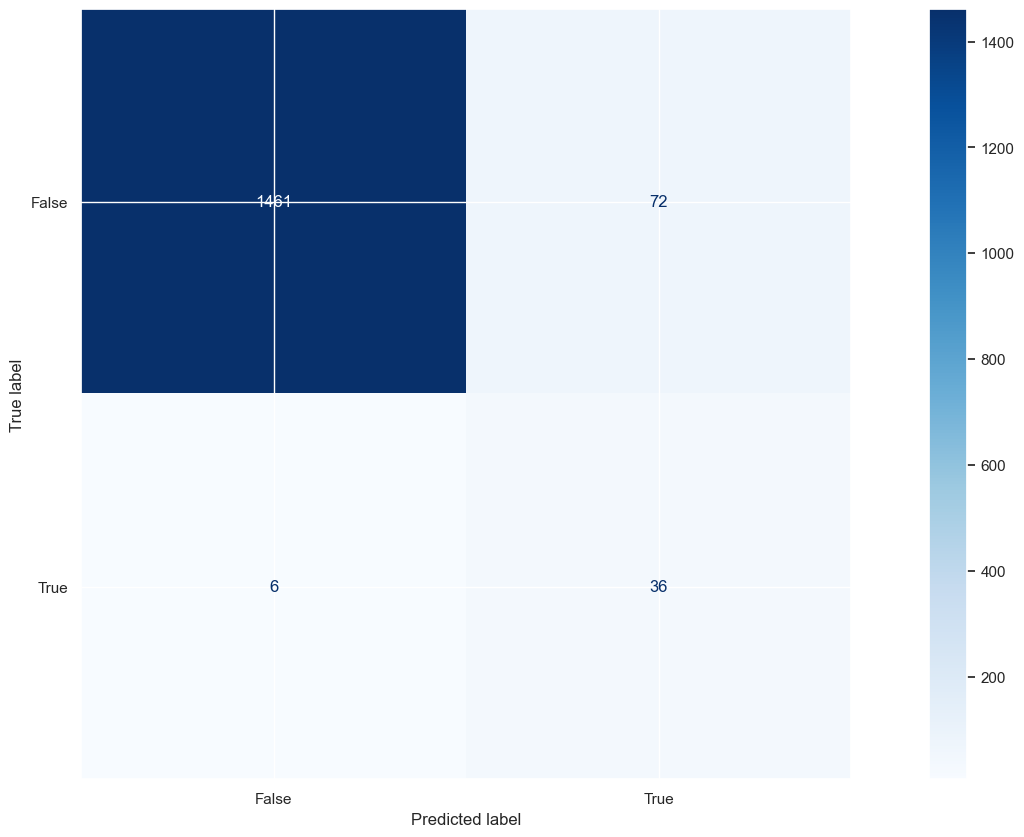

In [34]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, model_best.predict(X_test_cleaned)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 6. Add Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression, Ridge

In [39]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
def transform_data_for_regression(X):
    # "Cardinality" means the number of unique values in a column
    # Select categorical columns with relatively low cardinality (convenient but arbitrary)
    categorical_cols = [
        cname
        for cname in X.columns
        if X[cname].nunique() < 10 and X[cname].dtype == "object"
    ]

    # Select numerical columns
    numerical_cols = [
        cname for cname in X.columns if X[cname].dtype in ["int64", "float64"]
    ]

    # Preprocessing for numerical data
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant")),
            ("scaler", StandardScaler()),
            (
                "poly",
                PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
            ),
        ]
    )

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )
    return preprocessor.fit_transform(X)

In [ ]:
X_train_linear = transform_data_for_regression(X_train)

In [ ]:
X_train_linear

In [ ]:
pca = PCA(n_components=50, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

In [10]:

logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

ValueError: could not convert string to float: 'https://samolet.ru/project/'

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(X_test)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV